# Water Management Single Scenario Analysis

This notebook provides a detailed analysis of a single scenario water allocation simulation. The analysis helps understand how different policies affect:
- Actor behavior and cooperation
- Water allocation and usage
- Economic and ecological impacts

## Setup and Configuration

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import src.core as wms
import random
import src.plot_analysis as gtp
import src.utils as utils
import src.policies.incentive_policies as eip
import src.policies.quota_policies as eqp
import seaborn as sns
from types import MethodType

## Policy Definition

Below we define two key policies that regulate water allocation:

1. **Quota Policy**: Determines how much water each actor is allowed to pump
2. **Incentive Policy**: Uses fines and subsidies to influence actor behavior

You can modify these policies to test different regulation strategies.

In [25]:
# Define quota policy - determines how much water each actor is allowed to pump
# This uses the hard_quota policy from the quota_policies module
# In crisis situations, actors with priority below the crisis level get zero quota
import copy


class CrisisLevel:
    NORMAL = -1.0
    ALERT = 0.0
    CRISIS = 1.0
    EXTREME_CRISIS = 2.0

# Par défaut on place le point d'inflexion sur 1 qui représente pour nous la valeur centrale
def logistic_scaled(x, k=1, PF=1, x0=1):
    return PF / (1 + np.exp(-k * (x - x0)))

def tuned_make_quota_function(self, params):
    """
    Based on given parameters it generate a quota policy.

    Returns:
        func: Quota policy.
    """
    def tuned_quota(
        self,
        crisis_level: int,
        actors_priority: np.ndarray,
        avg_pump: np.ndarray,
        DOE: float,
        DCR: float,
        ) -> np.ndarray:
        """
        Hard quota policy based on priority and crisis level.
        
        Sets quotas to zero for actors with priority less than the current crisis level.
        
        Args:
            crisis_level: Current water crisis level.
            actors_priority: Priority levels for each actor.
            avg_pump: Average pumping for each actor.
            DOE: Ecological optimal flow threshold.
            DCR: Crisis flow threshold.
            
        Returns:
            Array of water quotas for each actor.
        """

        # This will make higher priority actors having bigger quotas
        priority_factor = copy.copy(actors_priority)
        priority_factor = priority_factor.astype(int)
        scores = logistic_scaled(np.array([0, 1, 2]), k=params["PG"], PF=params["PF"])
        # print("scores", scores)
        # Création d'un tableau de même taille avec les bons scores
        priority_factor = np.array([scores[p] for p in priority_factor])


        # print("crisis_level", crisis_level)
        if crisis_level == CrisisLevel.NORMAL:
            # Actors will be assigned quotas aligned with their priority
            # This will help us evaluate cooperation within incentive policy
            return (avg_pump * priority_factor)
        
        else:
            # Crisis times we estimate the available water and we distribute it according to the priority of the actors 
            # Until it reach the ecological acceptable flow
            maximum_amount = 0.0

            match crisis_level:
                case CrisisLevel.ALERT:
                    maximum_amount = DOE 
                case CrisisLevel.CRISIS:
                    maximum_amount = (DOE + DCR) / 2 
                case CrisisLevel.EXTREME_CRISIS:
                    # When already bellow the ecological flow, we don't want anyone to pump
                    return np.zeros_like(avg_pump)

            estimated_flow =  maximum_amount * params["WF_EF"]

            # Repartition by actor priority
            # Sort actors by priority, get indices
            sorted_indices = np.argsort(-actors_priority)
            quotas = np.zeros_like(avg_pump)

            for idx in sorted_indices:
                if estimated_flow <= DCR:
                    # If the remaining water is less than DCR, stop allocating, default value already 0
                    break
                pump = (avg_pump[idx] * 
                        params["PUR"] *
                        priority_factor[idx])
                if estimated_flow - pump >= DCR:
                    quotas[idx] = pump
                    estimated_flow -= pump
                else:
                    # If the remaining water is less than DCR the actor can't pump
                    quotas[idx] = 0

            return quotas
    return tuned_quota


def tuned_make_incentive_function(self, params):
    """
    Based on given parameters it generate an incentive policy.

    Returns:
        func: Incentive policy.
    """
    def tuned_incentive_policy(self,
                        actions: np.ndarray,
                        actors_priority: np.ndarray,
                        avg_incomes: np.ndarray,
                        water_pump: np.ndarray,
                        avg_pump: np.ndarray,
                        is_crisis: np.ndarray,
                        water_flows: np.ndarray,
                        quota: np.ndarray,
                        DOE = 15,
                        DCR = 10) -> np.ndarray:
        """
        Custom incentive policy that applies fines for exceeding quota and subsidies for cooperation.
        
        Returns an array of incentives (positive values = fines, negative values = subsidies)
        """
        fine = np.zeros(self.nb_actors)
        crisis_level = is_crisis[-1]  # Current crisis level
        
        # If average income is negative, replace it with 0
        avg_incomes = np.where(avg_incomes < 0, 0, avg_incomes)

        # Defining a custom treshold that represent an anticipation crisis point based on DCR multiple
        critical_overall_demand_treshold = params["WF_SF"] * DCR

       # This will make higher priority actors having bigger quotas
        priority_factor = copy.copy(actors_priority)
        
        
        priority_factor = copy.copy(actors_priority)
        priority_factor = priority_factor.astype(int)
        scores = logistic_scaled(np.array([0, 1, 2]), k=params["PG"], PF=params["PF"])

        # Création d'un tableau de même taille avec les bons scores
        priority_factor = np.array([scores[p] for p in priority_factor])

        # print("params[PF]", params["PF"])
        # print("params[PG]", params["PG"])
        # print("priority_factor", priority_factor)

        # As the simulation penalizes less subsidies we push more on it than fines
        SUBSIDY = -(
            # We make 5 times bigger subsidy as the simulation penalize 5 times less
            # So our politics align with the game rules and prefer pushing coop through subsidies rather than fines 
            (DCR * params["SUB_BC"] ) * 
            (1 / priority_factor)
        )

        FINE = (
            (avg_incomes * params["FIN_BC"]) * 
            (1 / priority_factor)
        )


        exceding_quota_idx = water_pump > quota
        respecting_quota_idx = water_pump <= quota

        if water_flows[-1] < critical_overall_demand_treshold and crisis_level == CrisisLevel.NORMAL:
            # We anticipate a near crisis situation so we start applying fines
            # But it won't be as strong as in a real crisis

            fine[exceding_quota_idx] = FINE[exceding_quota_idx] * params["ANT_C_F"]
            fine[respecting_quota_idx] = SUBSIDY[respecting_quota_idx] * params["ANT_C_F"]
        else:

            match crisis_level:
                case CrisisLevel.NORMAL:
                    fine[exceding_quota_idx] = FINE[exceding_quota_idx] * params["ANT_N_F"]
                    fine[respecting_quota_idx] = SUBSIDY[respecting_quota_idx] * params["ANT_N_F"]
                    return fine
                
                case CrisisLevel.ALERT | CrisisLevel.CRISIS | CrisisLevel.EXTREME_CRISIS :
                    
                    if crisis_level == CrisisLevel.ALERT:
                        crisis_factor =  params["CF"]
                    elif crisis_level == CrisisLevel.CRISIS:
                        crisis_factor = params["CF"] + params["CG"]
                    elif crisis_level == CrisisLevel.EXTREME_CRISIS:
                        crisis_factor = params["CF"] + 2 *params["CG"]
                    else:
                        print("WTF happening ?")
                        print("crisis_level", crisis_level)
                    
                    actors_priority_below_crisis = actors_priority < crisis_level
                    actors_priority_above_crisis = actors_priority >= crisis_level

                    # Defectors
                    # Below priority and exceeding
                    actors_exceding_and_below_priority_idx = actors_priority_below_crisis == exceding_quota_idx
                    fine[actors_exceding_and_below_priority_idx] = (
                            FINE[actors_exceding_and_below_priority_idx] * 
                            params["PF"] *
                            crisis_factor
                        )
                    # Above priority and exceeding
                    actors_exceding_and_above_priority_idx = actors_priority_above_crisis == exceding_quota_idx
                    fine[actors_exceding_and_above_priority_idx] = FINE[actors_exceding_and_above_priority_idx]

                    # Cooperators
                    # Below priority and respecting
                    actors_respecting_and_below_priority_idx = actors_priority_below_crisis == respecting_quota_idx
                    fine[actors_respecting_and_below_priority_idx] =(
                            SUBSIDY[actors_respecting_and_below_priority_idx] * 
                            params["PF"] * 
                            crisis_factor
                        )
                    # Above priority and respecting
                    actors_respecting_and_above_priority_idx = actors_priority_above_crisis == respecting_quota_idx
                    fine[actors_respecting_and_above_priority_idx] = SUBSIDY[actors_respecting_and_above_priority_idx]

                    return fine
        return fine
    return tuned_incentive_policy


def tuned_generate_individuals(self):
    """
    Generate required params for both policies.

    Returns:
        dict: Dictionary containing parameters for both incentive and quota policies \n
        {
            "param_name": init_value_func,
        }
    """
    return {
        "PF": random.uniform(0.1, 2),
        "PG": random.uniform(0.4, 5),
        "WF_EF": random.uniform(0.05, 0.95),
        "PUR": random.uniform(0.05, 1.5),
        "SUB_BC" : random.uniform(1, 20),
        "FIN_BC" : random.uniform(0.05, 0.75),
        "WF_SF": random.uniform(3, 20),
        "ANT_C_F": random.uniform(0.15, 0.8),
        "ANT_N_F": random.uniform(0.05, 0.8),
        "CF": random.uniform(1.2, 3),
        "CG": random.uniform(0.15, 0.9)
    }

## Simulation Configuration and Execution

Now we'll configure and run the simulation with our defined policies:

In [26]:
# Configure simulation parameters
from src.optim import EvolutionnarySearch


yaml_path = 'parameters/scenarios/0.yml'  
params = utils.load_parameters_from_yaml(yaml_path)
params["total_turns"] = 500        # Number of weeks to simulate
params["nb_iterations"] = 10       # Number of simulation runs
params["scarcity"] = "medium"      # Water scarcity level
params["global_forecast_bias"] = -.5       # Bias in water flow forecasts
params["global_forecast_uncertainty"] = .9  # Uncertainty in forecasts
params["verbose"] = True  # Uncertainty in forecasts

# Initialize and run simulation
base_simulation = wms.WaterManagementSimulation(**params)

N_GEN = 12

search = EvolutionnarySearch(
    simulation=base_simulation,
    p_best_parents=2,
    pop_size=12,
    n_gen=N_GEN,
    mutation_rate=0.5, # Only 50% of genes will mutate at each generation, the less it is, the more stable evolution will be
    initial_mutation_spread=0.5, # Mutation will follow a random mutation (increase or decrease) in a normally distributed factor centered around 1, with your desired standard deviation (the bigger it gets, the bigger changes will be)  
    ecol_weight=1.1, # Focus a bit more on ecological impact
    econ_weight=1,
    # score_metric="priority_order"
)

# Faut encore modifier les fonctions en make fonction et créer l'intialiseur
search.make_incentive_function = MethodType(tuned_make_incentive_function, search)
search.make_quota_function = MethodType(tuned_make_quota_function, search)
search.generate_individuals = MethodType(tuned_generate_individuals, search)

execution_results = search.run_search()

iteration gen 0 : 1
High satisfaction: 0.9018657531345703 Medium satisfaction: 0.7625736347767436 Low satisfaction: 0.754716279831478
----------------
ecological_impact 0.7925465838509317
economic_impact -1.5936306483617164
high_sat 0.9018657531345703
med_sat 0.7625736347767436
low_sat 0.754716279831478
adjusted_score -2.4654318905977415
ok_satisfaction 0.0
----------------
iteration gen 0 : 2
Violation: medium-priority actors must outperform low-priority actors by factor 1.000394
High satisfaction: 0.9018581134639025 Medium satisfaction: 0.7480435361026847 Low satisfaction: 0.7978108549809243
Penalty applied for medium-priority actors not outperforming low-priority actors.
----------------
ecological_impact 0.7627329192546584
economic_impact -4.083472132342298
high_sat 0.9018581134639025
med_sat 0.7480435361026847
low_sat 0.7978108549809243
adjusted_score -4.922478343522423
ok_satisfaction 0.0
----------------
iteration gen 0 : 3
High satisfaction: 0.8578881365008303 Medium satisfacti

In [27]:
filtered = [r for r in search.execution_results if r['ok_satisfaction'] == 1.0]

# Trouver celui avec le meilleur (max) adjusted_score
best_ind = max(filtered, key=lambda r: r['adjusted_score'])

print("Meilleur individu avec satisfaction ok == 1.0 :")
print(best_ind)

Meilleur individu avec satisfaction ok == 1.0 :
{'generation': 10, 'params': {'PF': 0.979239972650092, 'PG': 2.0196226476010555, 'WF_EF': 0.38324029640395, 'PUR': 0.7362651627765262, 'SUB_BC': 4.406270413998833, 'FIN_BC': 0.05194861642745999, 'WF_SF': 14.417632533328955, 'ANT_C_F': 0.4342184550903819, 'ANT_N_F': 0.6449669797766914, 'CF': 1.8060291910324024, 'CG': 0.5752085721381278}, 'ecological_impact': np.float64(0.7900621118012422), 'economic_impact': np.float64(0.0012117895562418872), 'adjusted_score': np.float64(-0.8678565334251246), 'ok_satisfaction': 1.0, 'high_sat': np.float64(0.8734605584895042), 'med_sat': np.float64(0.7747804674778523), 'low_sat': np.float64(0.7697156068516071), 'simulation': <src.core.WaterManagementSimulation object at 0x000001BEAF4CC140>}


In [28]:
# Extract succeed simulation
# best_ind = search.get_best_result()
simulation = best_ind["simulation"]
execution_results = search.execution_results

# Get final performance scores
ecological_impact, economic_impact, ok_satisfaction = simulation.get_final_scores_scaled()

print(f"Simulation complete. Final scores:")
print(f"Ecological Impact: {ecological_impact:.4f} (lower is better)")
print(f"Economic Impact: {economic_impact:.4f} (higher is better)")

# Prepare for visualization
sns.set(style='whitegrid')
cmap = plt.get_cmap('Dark2')
actors_colors = [cmap(i) for i in range(simulation.nb_actors)]
x_values = range(params["total_turns"])

High satisfaction: 0.8734605584895042 Medium satisfaction: 0.7747804674778523 Low satisfaction: 0.7697156068516071
Simulation complete. Final scores:
Ecological Impact: 0.7901 (lower is better)
Economic Impact: 0.0012 (higher is better)


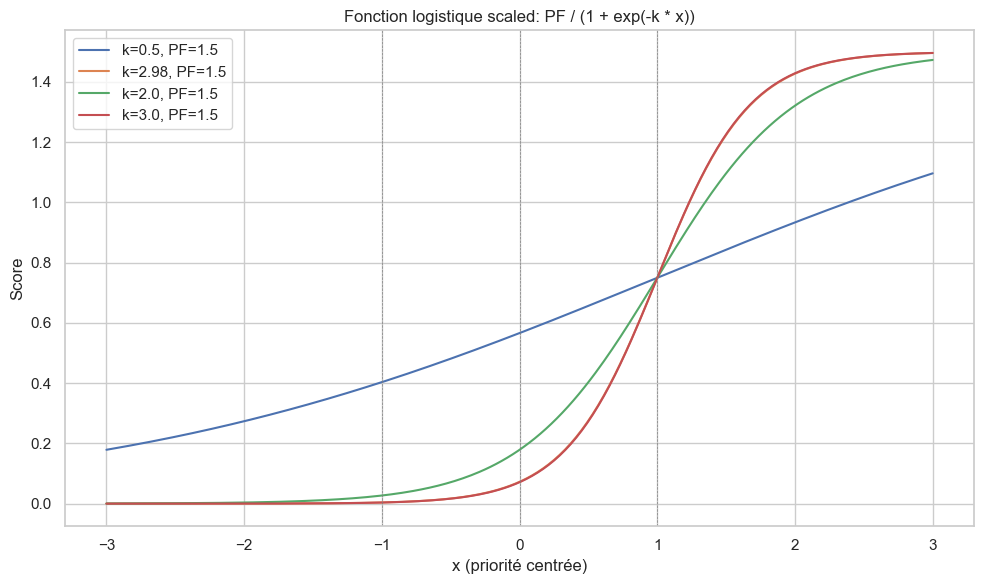

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_scaled(x, k=1, PF=1, x0=1):
    return PF / (1 + np.exp(-k * (x - x0)))

# Créer des x pour simuler les priorités (centrées sur 0)
x = np.linspace(-3, 3, 300)


# Tester plusieurs valeurs de k et PF
params = [
    {"k": 0.5, "PF": 1.5},
    {"k": 2.98, "PF": 1.5},
    {"k": 2.0, "PF": 1.5},
    {"k": 3.0, "PF": 1.5}
]

plt.figure(figsize=(10, 6))
for p in params:
    y = logistic_scaled(x, k=p["k"], PF=p["PF"])
    plt.plot(x, y, label=f'k={p["k"]}, PF={p["PF"]}')

# Ajouter des repères pour les priorités 0, 1, 2
for i in [-1, 0, 1]:
    plt.axvline(x=i, color="gray", linestyle="--", linewidth=0.5)

plt.title("Fonction logistique scaled: PF / (1 + exp(-k * x))")
plt.xlabel("x (priorité centrée)")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
import pandas as pd

pd.DataFrame(best_ind).to_csv("best_ind_v1.3_scenario_0_hgen.csv")

## 0. Generational analysis

In [31]:
import plotly.express as px
import pandas as pd

incentive_data = [row['params'] for row in execution_results]
# quota_data = [row['quota_params'] for row in execution_results]
ecological_impact = [row['ecological_impact'] for row in execution_results]
economic_impact = [row['economic_impact'] for row in execution_results]
h_satisfaction_data = {}
m_satisfaction_data = {}
l_satisfaction_data = {}
h_satisfaction_data["h_s"] = [row['high_sat'] for row in execution_results]
m_satisfaction_data["m_s"] = [row['med_sat'] for row in execution_results]
l_satisfaction_data["l_s"] = [row['low_sat'] for row in execution_results]
gen_data = {}
gen_data["generation"] = [row['generation'] for row in execution_results]

df_gen = pd.DataFrame(gen_data)
df_incentive = pd.DataFrame(incentive_data)
# df_quota = pd.DataFrame(quota_data)
df_satisfaction_h = pd.DataFrame(h_satisfaction_data)
df_satisfaction_m = pd.DataFrame(m_satisfaction_data)
df_satisfaction_l = pd.DataFrame(l_satisfaction_data)
df_impact = pd.DataFrame({
    "ecol": ecological_impact,
    "econ": economic_impact
})

df = pd.concat([df_gen,
                df_incentive,
                df_impact,
                df_satisfaction_h,
                df_satisfaction_m,
                df_satisfaction_l,
                ], axis=1)

fig = px.parallel_coordinates(
    df,
    color="generation",
    dimensions=df.columns,
    color_continuous_scale=px.colors.diverging.Temps,
    color_continuous_midpoint=N_GEN/2
)

fig.show()

med_sat = df["l_s"] > df["m_s"]
high_sat = df["h_s"] > df["m_s"]
comb = high_sat == med_sat
econ_pos = df["econ"] > -0.5

fig = px.parallel_coordinates(
    df[econ_pos],
    color="generation",
    dimensions=df.columns,
    color_continuous_scale=px.colors.diverging.Temps,
    color_continuous_midpoint=N_GEN/2,
)

fig.show()


In [32]:
best_incentive_data = best_ind['params']
best_ecological_impact = best_ind['ecological_impact']
best_economic_impact = best_ind['economic_impact']
best_satisfaction_data = {}
best_satisfaction_data["prio_ok"] = best_ind['ok_satisfaction']
best_gen_data = {}
best_gen_data["generation"] = best_ind['generation']

df_best_gen = pd.DataFrame(best_gen_data, index=[0])
df_best_incentive = pd.DataFrame(best_incentive_data, index=[0])
df_best_satisfaction = pd.DataFrame(best_satisfaction_data, index=[0])
df_best_impact = pd.DataFrame({
    "ecological_impact": best_ecological_impact,
    "economic_impact": best_economic_impact
}, index=[0])

best_df = pd.concat([
                # df_best_gen,
                df_best_incentive,
                # df_best_impact,
                # df_best_satisfaction
                ], axis=1)

In [33]:
import pandas as pd
import plotly.express as px

# Graphique en barres
fig = px.bar(best_df, x=best_df.columns,  title='Weight importances for best combinaison')
fig.show()


## 1. Water Resource Analysis

First, let's examine the water resource availability throughout the simulation period and how it relates to actor demands.

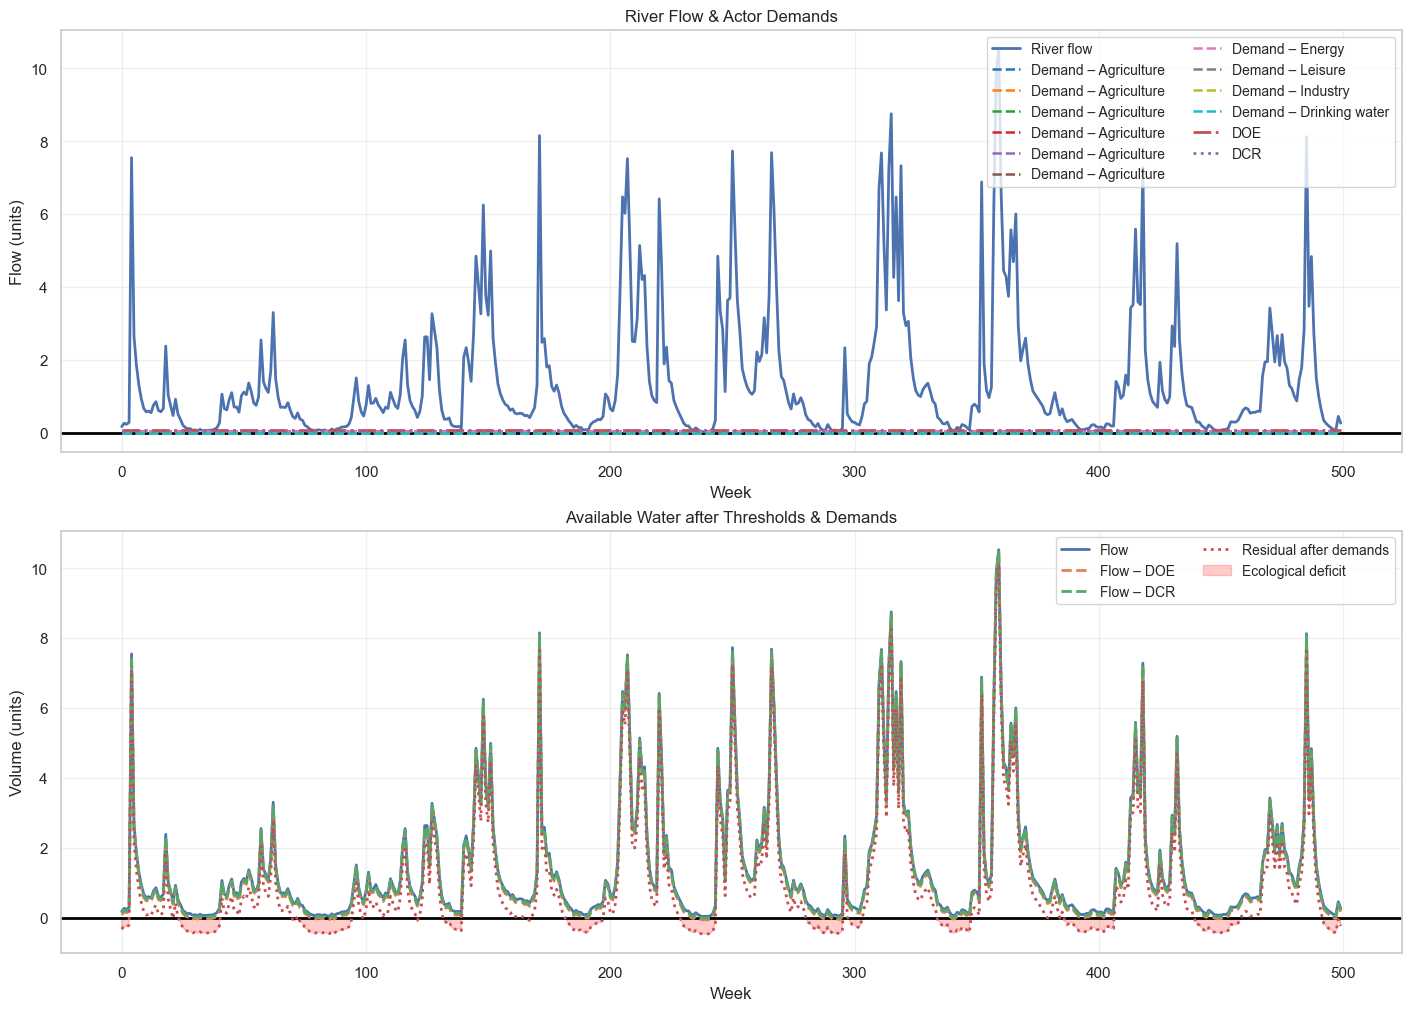

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot river flow
gtp.plot_river_flow(axes[0], x_values, simulation)

# Plot remaining water after ecological threshold
gtp.plot_remaining_water(axes[1], x_values, simulation)

plt.show()

### Analysis of Water Resources

The top graph shows the raw river flow over time, along with each actor's water demand and the ecological threshold (DCR). The total demand line shows the sum of all actor demands.

The bottom graph shows the remaining water available for allocation after respecting the ecological threshold. When this line drops below zero (red shaded areas), it indicates periods where fulfilling all demands would breach the minimum environmental flow requirements.

## 2. Actor Behavior and Crisis Response

Now, let's analyze how actors behave in response to changing water availability and crisis levels.

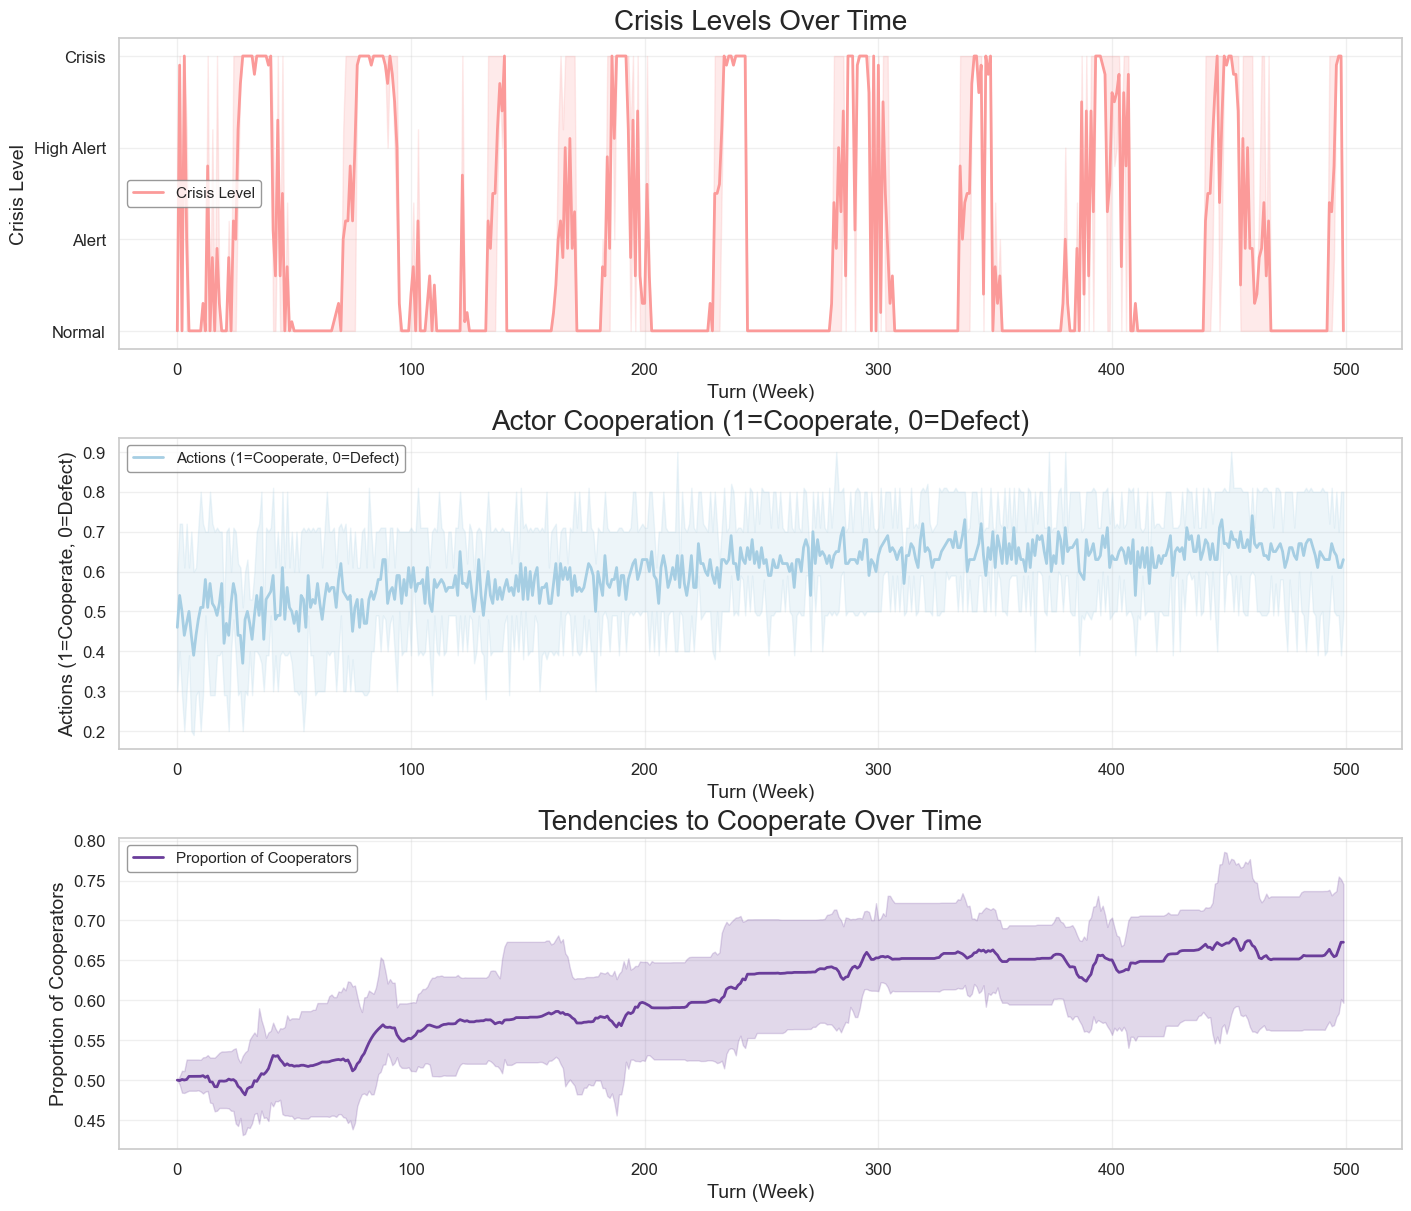

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot crisis levels
gtp.plot_data(axes[0], x_values, simulation, "w_crisis", mode="mean")
axes[0].set_title('Crisis Levels Over Time', fontsize=20)
axes[0].set_ylim(-1.2, 2.2)
axes[0].set_yticks([-1, 0, 1, 2])
axes[0].set_yticklabels(['Normal', 'Alert', 'High Alert', 'Crisis'])

# Plot actor cooperation actions
gtp.plot_data(axes[1], x_values, simulation, "h_actions", mode="mean")
axes[1].set_title('Actor Cooperation (1=Cooperate, 0=Defect)', fontsize=20)

# Plot tendencies to cooperate
gtp.plot_data(axes[2], x_values, simulation, "h_tendencies", mode="mean")
axes[2].set_title('Tendencies to Cooperate Over Time', fontsize=20)

plt.show()

### Analysis of Actor Behavior

These graphs reveal how actors respond to crisis situations:

- The **Crisis Level** graph shows when the system enters different states of water stress.
- The **Actor Cooperation** graph shows actors' decisions to either cooperate (1) or defect (0).
- The **Tendencies to Cooperate** graph shows the evolving probability of cooperation for each actor.

Notice how cooperation tendencies change in response to crisis events. This reveals how actors learn from experience and adapt their strategies based on outcomes.

## 3. Water Allocation and Economic Outcomes

Next, let's examine how water is allocated among actors and its economic impacts.

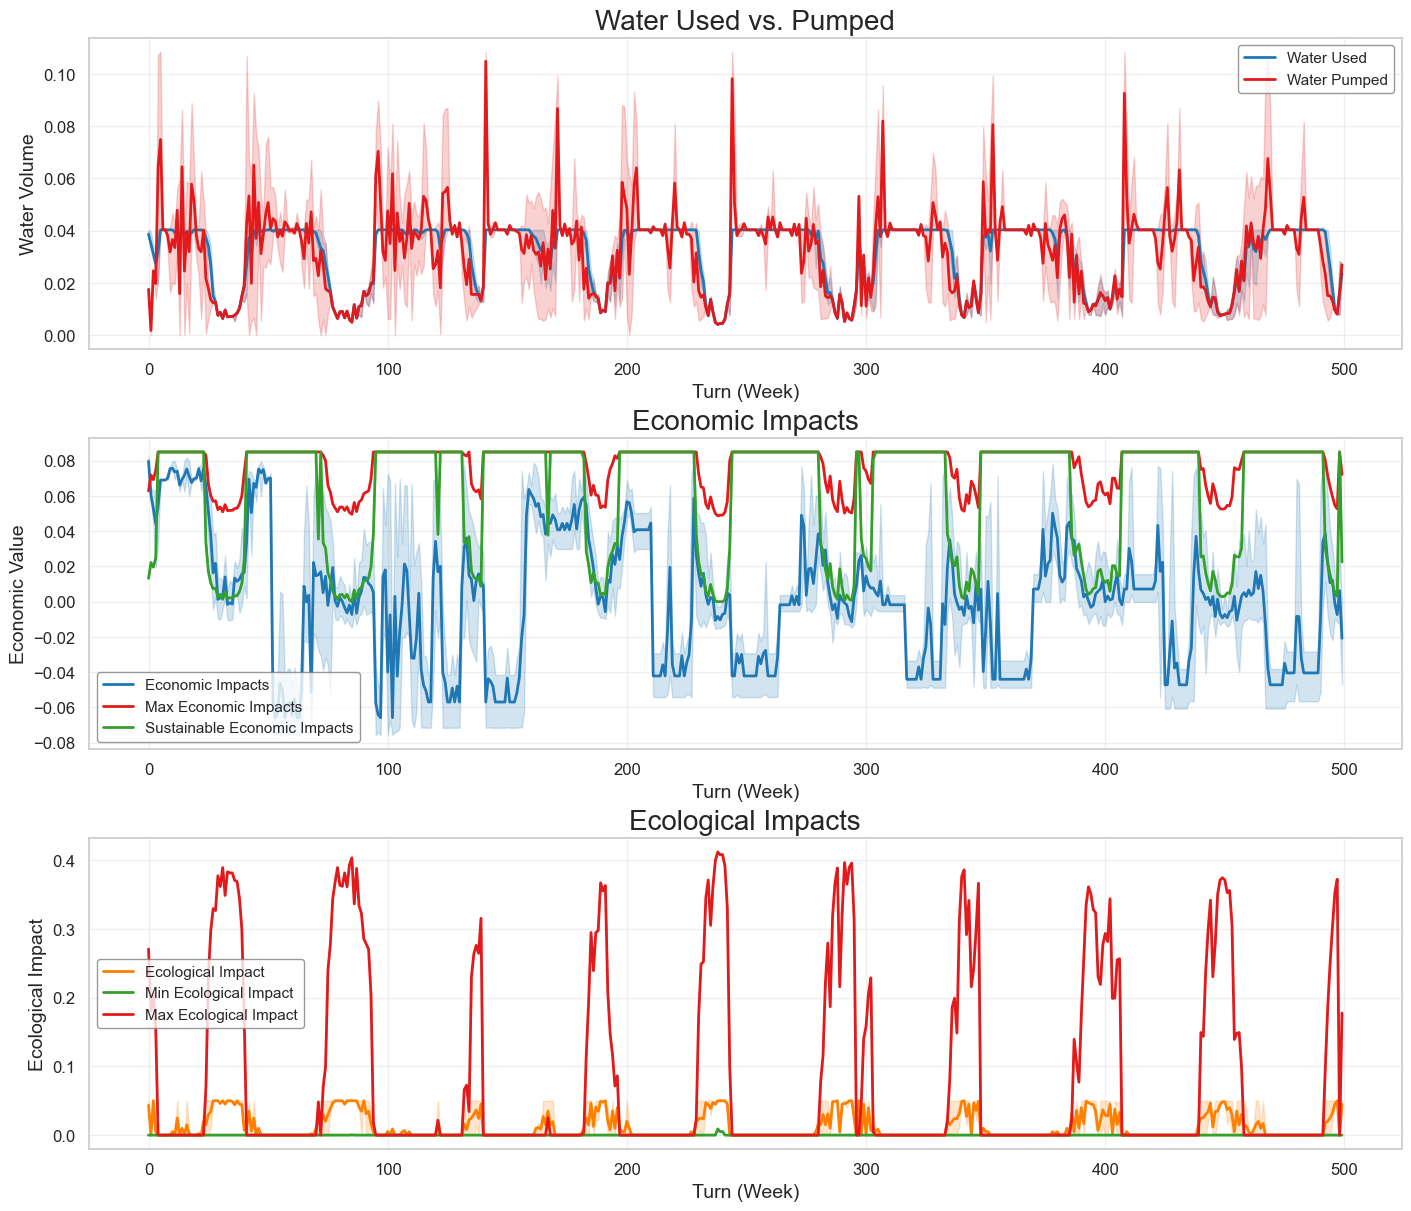

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot water usage
gtp.compare_data(
    axes[0], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Water Volume',
    title='Water Used vs. Pumped'
)

# Plot economic impacts
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Economic Value',
    title='Economic Impacts'
)

# Plot ecological impacts
gtp.compare_data(
    axes[2], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Ecological Impact',
    title='Ecological Impacts'
)

plt.show()

### Analysis of Allocation and Impacts

These graphs show the outcomes of the water allocation process:

- **Water Used vs. Pumped**: Compares water pumped from the river to water actually used. The difference goes into storage.
- **Economic Impacts**: Shows the actual economic value generated compared to theoretical maximum and sustainable minimum values.
- **Ecological Impacts**: Shows the environmental impact of water usage compared to minimum and maximum possible impacts.

These metrics help evaluate how well the policy balances economic benefits against ecological integrity.

## 4. Policy Effectiveness Analysis

Now let's analyze how the incentive policy (fines and subsidies) influenced actor behavior.

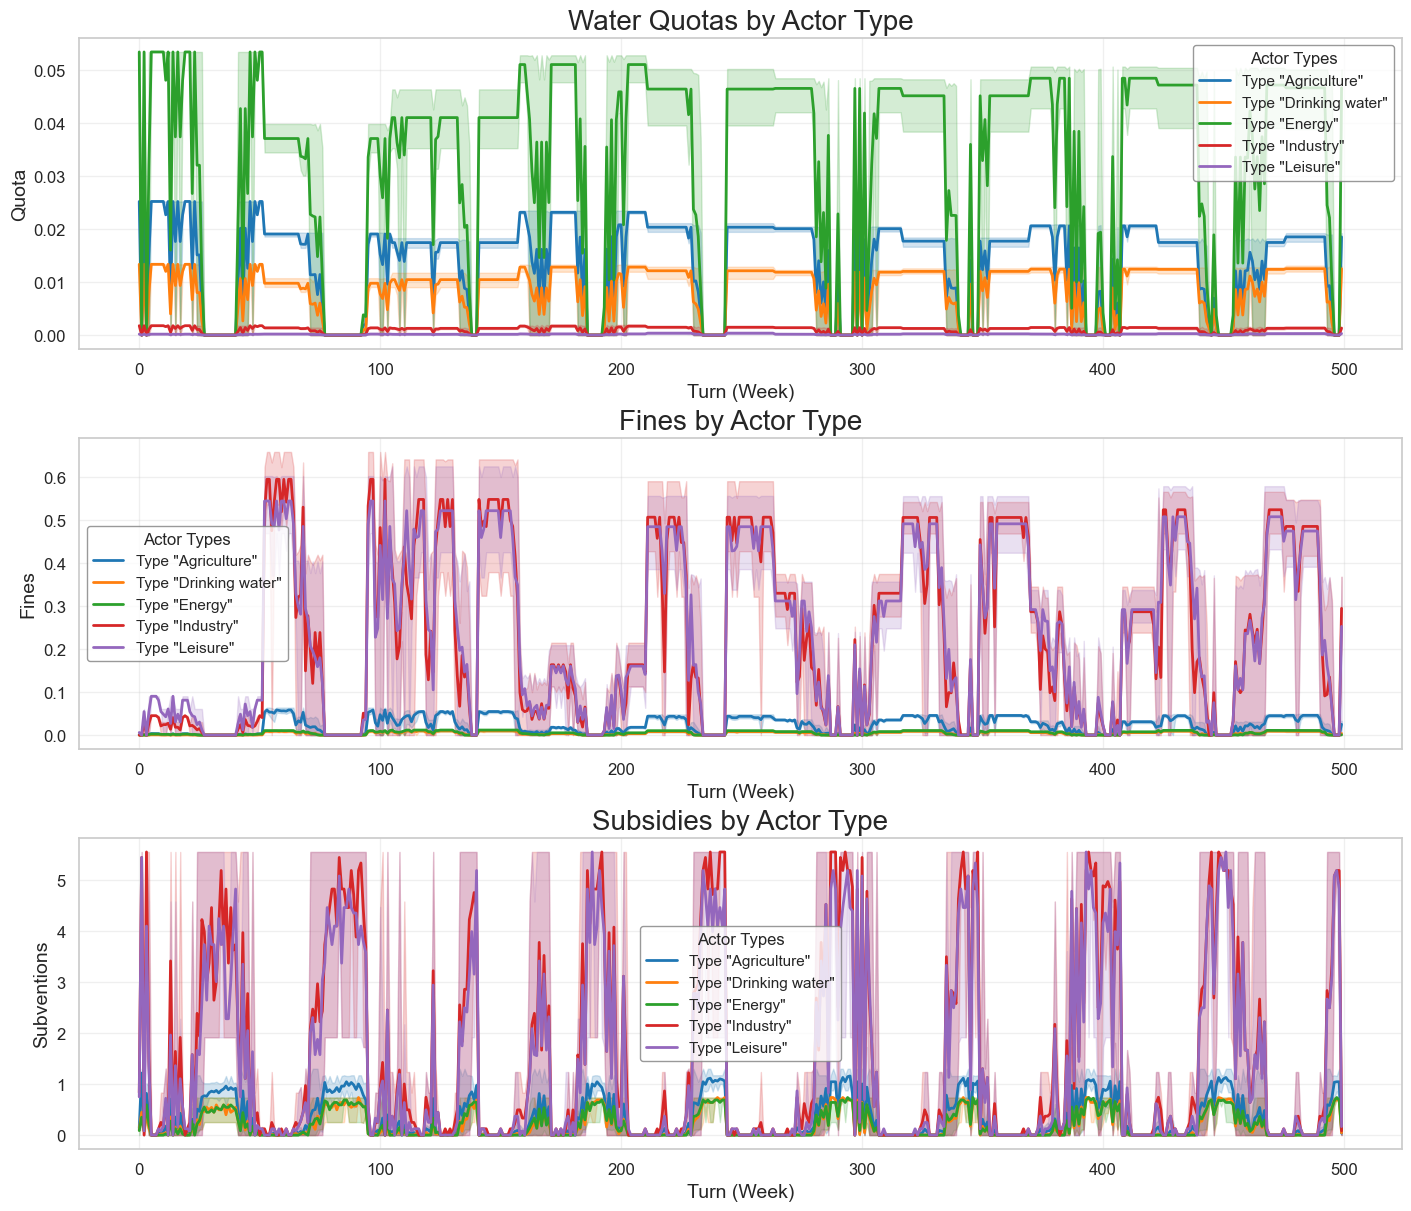

In [37]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Plot quotas by actor type
gtp.plot_actor_data_by_type(axes[0], x_values, simulation, "h_quota", mode="actors_mean")
axes[0].set_title('Water Quotas by Actor Type', fontsize=20)

# Plot fines and subsidies 
gtp.plot_actor_data_by_type(axes[1], x_values, simulation, "h_fines", mode="actors_mean")
axes[1].set_title('Fines by Actor Type', fontsize=20)

gtp.plot_actor_data_by_type(axes[2], x_values, simulation, "h_subventions", mode="actors_mean")
axes[2].set_title('Subsidies by Actor Type', fontsize=20)

plt.show()

### Analysis of Policy Interventions

These graphs reveal how the incentive policy worked:

- **Water Quotas**: Shows the allowed water allocation for each actor type over time.
- **Fines**: Shows penalties applied when actors exceeded their quotas.
- **Subsidies**: Shows incentives given to encourage cooperation.

The effectiveness of these tools can be evaluated by comparing them to the cooperation tendencies seen earlier.

## 5. Cumulative Impact Analysis

Finally, let's examine the cumulative impacts over the entire simulation period.

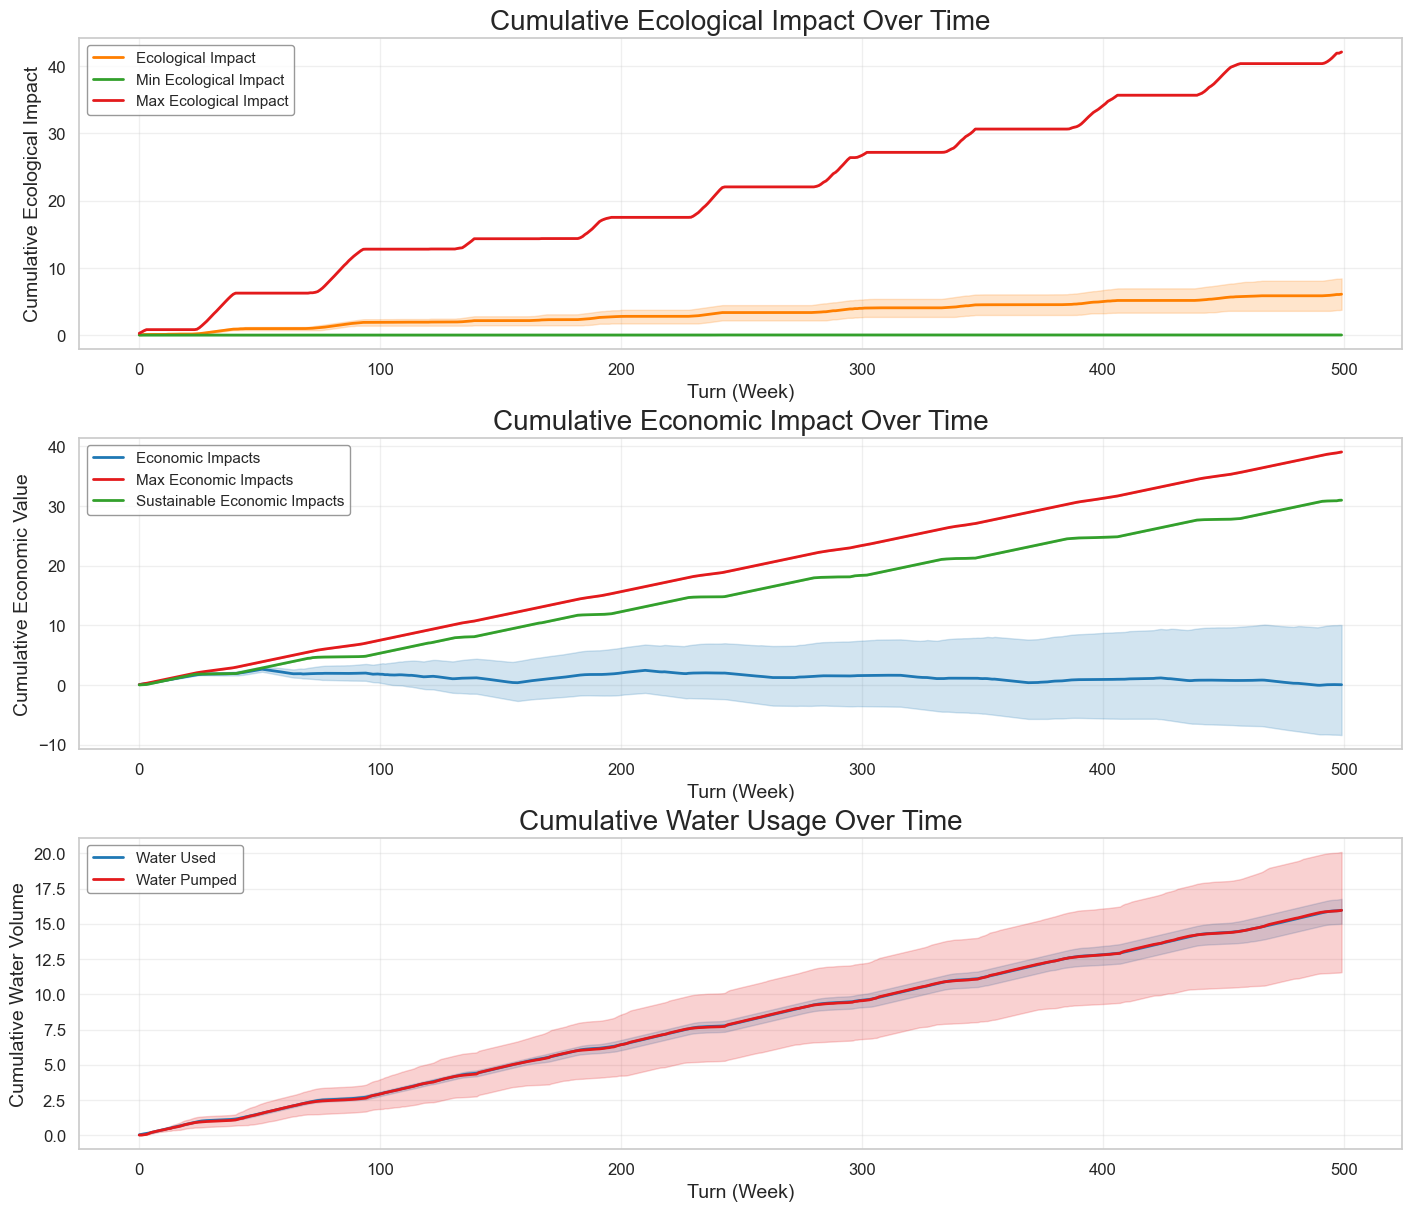

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), constrained_layout=True)

# Cumulative ecological impact
gtp.compare_data(
    axes[0], x_values,
    ['w_ecol_impact', 'w_min_ecol_impact', 'w_max_ecol_impact'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Ecological Impact',
    title='Cumulative Ecological Impact Over Time',
    cumulative=True
)

# Cumulative economic impact
gtp.compare_data(
    axes[1], x_values,
    ['h_econ_impacts', 'h_max_econ_impacts', 'h_min_econ_impacts'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Economic Value',
    title='Cumulative Economic Impact Over Time',
    cumulative=True
)

# Cumulative water usage
gtp.compare_data(
    axes[2], x_values,
    ['h_water_used', 'h_water_pump'],
    simulation,
    xlabel='Turn (Week)',
    ylabel='Cumulative Water Volume',
    title='Cumulative Water Usage Over Time',
    cumulative=True
)

plt.show()

### Analysis of Cumulative Impacts

These graphs show the long-term, cumulative outcomes of the policy:

- **Cumulative Ecological Impact**: Shows the total environmental impact over time.
- **Cumulative Economic Impact**: Shows the total economic value generated over time.
- **Cumulative Water Usage**: Shows the total water pumped and used over time.

These cumulative metrics are useful for evaluating the overall performance of the policy across the entire simulation period.

## 6. Actor-Specific Analysis

For a deeper understanding, let's examine how individual actors behaved.

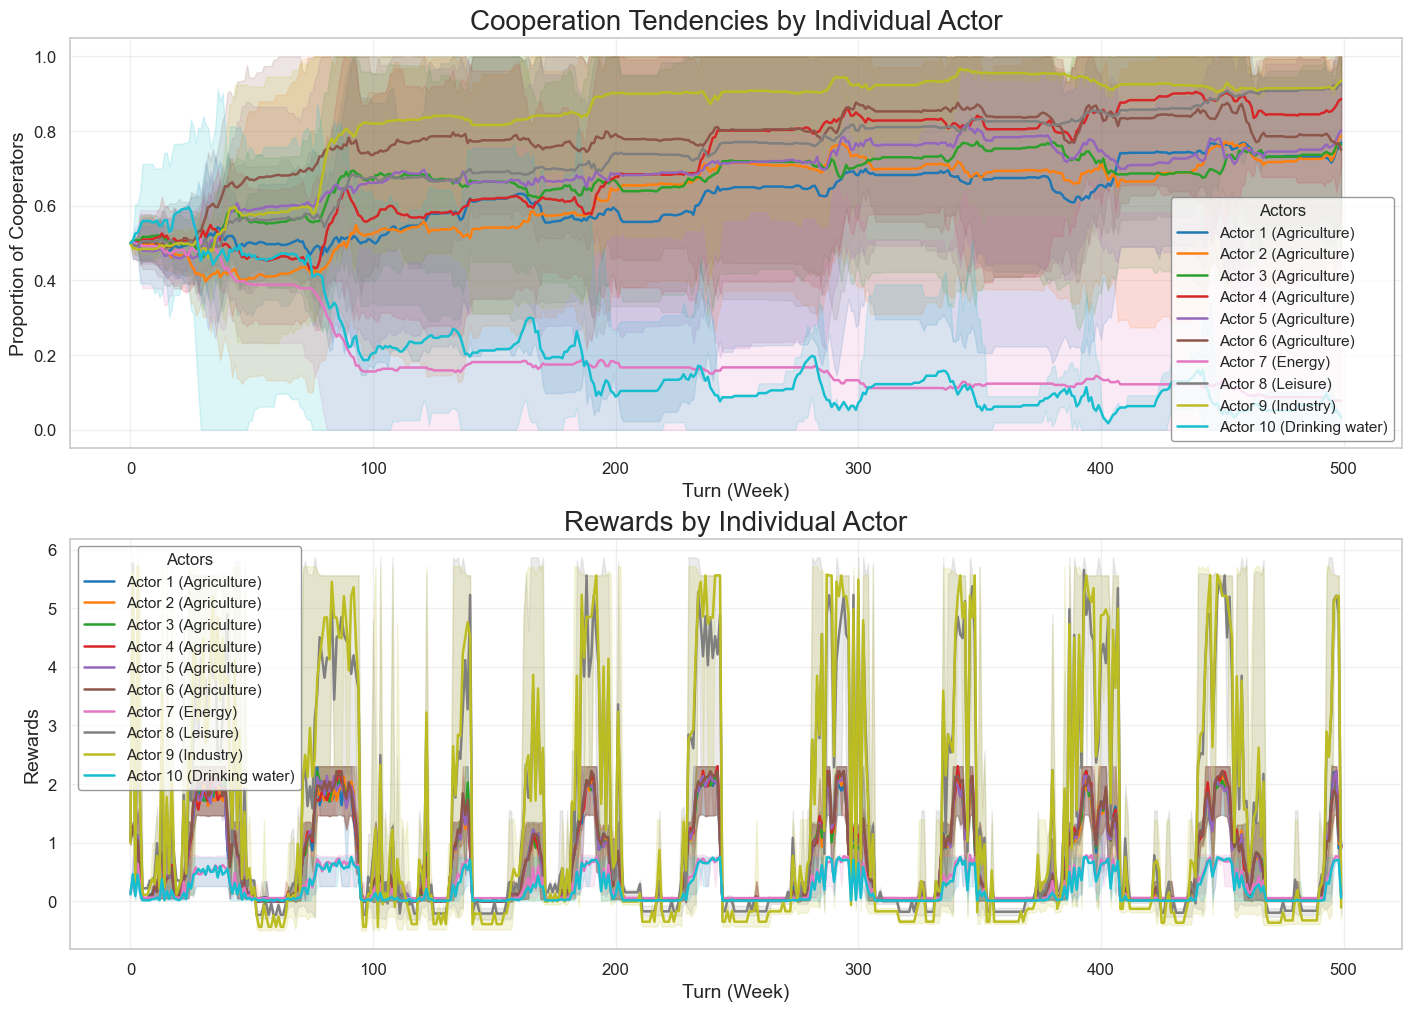

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), constrained_layout=True)

# Plot cooperation tendencies for individual actors
gtp.plot_actor_data(axes[0], x_values, simulation, "h_tendencies")
axes[0].set_title('Cooperation Tendencies by Individual Actor', fontsize=20)

# Plot rewards for individual actors
gtp.plot_actor_data(axes[1], x_values, simulation, "h_rewards")
axes[1].set_title('Rewards by Individual Actor', fontsize=20)

plt.show()

### Analysis of Individual Actor Behavior

These graphs provide actor-specific insights:

- **Cooperation Tendencies**: Shows how each individual actor's tendency to cooperate evolved over time.
- **Rewards**: Shows the economic rewards received by each actor.

Notice how different actors may have different strategies based on their priority, demand, and other characteristics.

## Conclusion

This analysis demonstrates how water allocation policies can influence actor behavior and overall system outcomes. The key insights are:

1. Water scarcity triggers crisis situations that require cooperation to manage effectively
2. Actors adapt their behavior based on incentives and outcomes
3. Policies must balance economic benefits against ecological integrity
4. Different actor types respond differently to incentives based on their priorities and needs

By testing different policy settings in this simulation, you can develop more effective water management strategies that promote cooperation while maintaining environmental flows.

## Next Steps

To further improve the policy, consider:

1. Adjusting quota calculations based on precise water availability
2. Fine-tuning incentive levels to better influence cooperation
3. Testing different policy combinations under various scarcity scenarios
4. Adding additional mechanisms like water trading or resource pooling